In [7]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Lab | Natural Language Processing
### SMS: SPAM or HAM

### Let's prepare the environment

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

- Read Data for the Fraudulent Email Kaggle Challenge
- Reduce the training set to speead up development. 

In [12]:
## Read Data 

# Load the datasets
training_data = pd.read_csv(r"C:\Users\sombe\Downloads\kg_train.csv")
test_data = pd.read_csv(r"C:\Users\sombe\Downloads\kg_test.csv")

# Subset the datasets
training_data = training_data.head(1000)  # Use the first 1000 rows for training
test_data = test_data.head(250)  # Use the first 250 rows for testing

# Print the shapes to verify
print("Training data shape:", training_data.shape)
print("Test data shape:", test_data.shape)

print("Training Data Columns:")
print(training_data.columns)

print("Test Data Columns:")
print(test_data.columns)


Training data shape: (1000, 2)
Test data shape: (250, 1)
Training Data Columns:
Index(['text', 'label'], dtype='object')
Test Data Columns:
Index(['text'], dtype='object')


### Let's divide the training and test set into two partitions

## Data Preprocessing

In [16]:
import string
from nltk.corpus import stopwords
print(string.punctuation)
print(stopwords.words("english")[100:110])
from nltk.stem.snowball import SnowballStemmer
snowball = SnowballStemmer('english')

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
['here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each']


In [76]:
import re

def add_spaces_around_special_chars(text):
    """
    Adds spaces around special characters to ensure proper tokenization.
    """
    text = re.sub(r'([.,!?;()=<>-])', r' \1 ', text)  # Add spaces around punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text


In [78]:
# Apply to both datasets
training_data['text'] = training_data['text'].astype(str).apply(add_spaces_around_special_chars)
test_data['text'] = test_data['text'].astype(str).apply(add_spaces_around_special_chars)

# Confirm changes
print("Training Data (First 5 Rows):")
print(training_data.head())

print("\nTest Data (First 5 Rows):")
print(test_data.head())


Training Data (First 5 Rows):
                                                text  label
0  DEAR SIR , STRICTLY PRIVATE BUSINESS PROPOSAL ...      1
1                                                  .      0
2  Nora - - Cheryl emailed dozens memos Haiti wee...      0
3  Dear Sir = 2FMadam = 2C know proposal might su...      1
4                                                fyi      0

Test Data (First 5 Rows):
                                                text
0  usiness fact deceased man foreigner not = auth...
1  happy adjust afternoon . going suggest 3:00pm ...
2  Lael Brainard confirmed 78 - 19 afternoon . Mi...
3  H < hrod17@clintonemail . com > Friday March 2...
4  n ; " > Dear Good Friend , < br > < br > < br ...


## Now, we have to clean the html code removing words

- First we remove inline JavaScript/CSS
- Then we remove html comments. This has to be done before removing regular tags since comments can contain '>' characters
- Next we can remove the remaining tags

In [80]:
import re
from html import unescape

# Step 1: Remove inline JavaScript and CSS
def remove_js_css(html_content):
    return re.sub(r'<(script|style).*?>.*?</\1>', '', html_content, flags=re.DOTALL)



In [82]:
# Step 2: Remove HTML comments
def remove_html_comments(html_content):
    return re.sub(r'<!--.*?-->', '', html_content, flags=re.DOTALL)



In [84]:

# Step 3: Remove all remaining HTML tags
def remove_html_tags(html_content):
    return re.sub(r'<[^>]+>', '', html_content)



In [86]:
# Step 4: Decode HTML entities and clean spaces
def clean_text(html_content):
    text = unescape(html_content)  # Decode HTML entities (e.g., &amp; → &, &lt; → <)
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

In [88]:
print("Training Data Columns:")
print(training_data.columns)

print("Test Data Columns:")
print(test_data.columns)

Training Data Columns:
Index(['text', 'label'], dtype='object')
Test Data Columns:
Index(['text'], dtype='object')


- Remove all the special characters
    
- Remove numbers
    
- Remove all single characters
 
- Remove single characters from the start

- Substitute multiple spaces with single space

- Remove prefixed 'b'

- Convert to Lowercase

In [104]:
import re

def clean_text(text):
    """Performs multiple text preprocessing steps in a single function."""
    if not isinstance(text, str):
        return ""

    # Step 1: Remove special characters (except letters, numbers, and spaces)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Step 2: Remove numbers
    text = re.sub(r'\d+', '', text)

    # Step 3: Remove all single characters
    text = re.sub(r'\b\w\b', '', text)

    # Step 4: Remove single characters at the start of the text
    text = re.sub(r'^[a-zA-Z]\s+', '', text)

    # Step 5: Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text).strip()

    # Step 6: Remove prefixed 'b' (e.g., from byte conversion artifacts)
    text = re.sub(r'\bb\s+', '', text)

    # Step 7: Convert to lowercase
    text = text.lower()

    return text

# Ensure text column is a string before applying the function
training_data['text'] = training_data['text'].astype(str).apply(clean_text)
test_data['text'] = test_data['text'].astype(str).apply(clean_text)

# Confirm changes
print("Training Data (First 5 Rows):")
print(training_data.head())

print("\nTest Data (First 5 Rows):")
print(test_data.head())


Training Data (First 5 Rows):
                                                text  label
0  dear sir strictly private business proposal mi...      1
1                                                         0
2  nora cheryl emailed dozens memos haiti weekend...      0
3  dear sir fmadam know proposal might surprise e...      1
4                                                fyi      0

Test Data (First 5 Rows):
                                                text
0  usiness fact deceased man foreigner authorized...
1  happy adjust afternoon going suggest pm start ...
2  lael brainard confirmed afternoon miguel rodri...
3  hrodclintonemail com friday march amsbwhoeop r...
4  dear good friend br br br happy inform succe s...


In [106]:
print("Training Data Columns:")
print(training_data.columns)

print("Test Data Columns:")
print(test_data.columns)

Training Data Columns:
Index(['text', 'label'], dtype='object')
Test Data Columns:
Index(['text'], dtype='object')


## Now let's work on removing stopwords
Remove the stopwords.

In [108]:
# Your code
import nltk
from nltk.corpus import stopwords
import re
nltk.download('stopwords')

# Load English stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sombe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [110]:
def remove_stopwords(text):
    words = text.split()  # Tokenize text into words
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)  # Join back into a single string

# Apply stopword removal to both datasets
training_data['text'] = training_data['text'].apply(remove_stopwords)
test_data['text'] = test_data['text'].apply(remove_stopwords)


In [112]:
# Confirm changes
print("Training Data (First 5 Rows):")
print(training_data.head())

print("\nTest Data (First 5 Rows):")
print(test_data.head())

Training Data (First 5 Rows):
                                                text  label
0  dear sir strictly private business proposal mi...      1
1                                                         0
2  nora cheryl emailed dozens memos haiti weekend...      0
3  dear sir fmadam know proposal might surprise e...      1
4                                                fyi      0

Test Data (First 5 Rows):
                                                text
0  usiness fact deceased man foreigner authorized...
1  happy adjust afternoon going suggest pm start ...
2  lael brainard confirmed afternoon miguel rodri...
3  hrodclintonemail com friday march amsbwhoeop r...
4  dear good friend br br br happy inform succe s...


## Tame Your Text with Lemmatization
Break sentences into words, then use lemmatization to reduce them to their base form (e.g., "running" becomes "run"). See how this creates cleaner data for analysis!

In [114]:
# Your code

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# Download resources if not already installed
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

def get_wordnet_pos(word):
    """ Map POS tag to first character for lemmatizer """
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)  # Default to noun if tag not found

def lemmatize_text(text):
    """ Tokenize text and apply lemmatization """
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(text)  # Tokenize sentence into words
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words]
    return ' '.join(lemmatized_words)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sombe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sombe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\sombe\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


In [128]:
nltk.download('all')  # All to resolve the error of nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\sombe\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\abc.zip.
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\sombe\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\sombe\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     C:\Users\sombe\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\sombe\AppData\Roaming\nltk_data...
[nltk_data]    | 

True

In [134]:
# Apply lemmatization to both datasets
training_data['text'] = training_data['text'].astype(str).apply(lemmatize_text)
test_data['text'] = test_data['text'].astype(str).apply(lemmatize_text)

# Confirm changes
print("Training Data (First 5 Rows):")
print(training_data.head())

print("\nTest Data (First 5 Rows):")
print(test_data.head())



Training Data (First 5 Rows):
                                                text  label
0  dear sir strictly private business proposal mi...      1
1                                                         0
2  nora cheryl email dozen memo haiti weekend ple...      0
3  dear sir fmadam know proposal might surprise e...      1
4                                                fyi      0

Test Data (First 5 Rows):
                                                text
0  usiness fact decease man foreigner authorize l...
1  happy adjust afternoon go suggest pm start tim...
2  lael brainard confirm afternoon miguel rodrigu...
3  hrodclintonemail com friday march amsbwhoeop r...
4  dear good friend br br br happy inform succe s...


In [136]:
print(training_data[['text']].head(10))
print(test_data[['text']].head(10))

                                                text
0  dear sir strictly private business proposal mi...
1                                                   
2  nora cheryl email dozen memo haiti weekend ple...
3  dear sir fmadam know proposal might surprise e...
4                                                fyi
5  sure bottom line need special security code ge...
6  dear sir engr ugo nzego engineering store depa...
7  abedin huma abedinhstate gov saturday november...
8  oct th george marshall event department tentat...
9  account owner br colleague br set aside defray...
                                                text
0  usiness fact decease man foreigner authorize l...
1  happy adjust afternoon go suggest pm start tim...
2  lael brainard confirm afternoon miguel rodrigu...
3  hrodclintonemail com friday march amsbwhoeop r...
4  dear good friend br br br happy inform succe s...
5  faithfully cdr abdul siop edirector fgeneral e...
6  need time thursday friday see holbrooke mar

## Bag Of Words
Let's get the 10 top words in ham and spam messages (**EXPLORATORY DATA ANALYSIS**)

In [138]:
pip install scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [162]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer


In [142]:
# Your code

# Separate ham and spam messages
ham_messages = training_data[training_data['label'] == 0]['text']
spam_messages = training_data[training_data['label'] == 1]['text']


In [172]:
print("Sample Ham Messages:\n", ham_messages.head())
print("Sample Spam Messages:\n", spam_messages.head())

Sample Ham Messages:
 1                                                     
2    nora cheryl email dozen memo haiti weekend ple...
4                                                  fyi
5    sure bottom line need special security code ge...
7    abedin huma abedinhstate gov saturday november...
Name: text, dtype: object
Sample Spam Messages:
 0     dear sir strictly private business proposal mi...
3     dear sir fmadam know proposal might surprise e...
6     dear sir engr ugo nzego engineering store depa...
9     account owner br colleague br set aside defray...
10    strong href dhttpwww cnn comworldafricakenya c...
Name: text, dtype: object


In [174]:
def get_top_words(text_series, n=10):
    print("Number of messages in input:", len(text_series))  # Check input size

    vectorizer = CountVectorizer(stop_words='english')  # Remove stopwords
    X = vectorizer.fit_transform(text_series)
    
    if X.shape[0] == 0:  # Check if the output is empty
        print("No words found after vectorization.")
        return []

    # Sum word occurrences
    word_counts = X.toarray().sum(axis=0)

    # Get words and their frequencies
    word_freq = dict(zip(vectorizer.get_feature_names_out(), word_counts))

    # Get the top N words
    top_words = Counter(word_freq).most_common(n)

    print("\n**Top Words Found:**", top_words)  # Debugging output
    return top_words





In [176]:
top_ham_words = get_top_words(ham_messages)
top_spam_words = get_top_words(spam_messages)

print("\n📌 **Top 10 Words in Ham Messages:**")
print(top_ham_words)

print("\n📌 **Top 10 Words in Spam Messages:**")
print(top_spam_words)


Number of messages in input: 558

📌 **Top Words Found:** [('pm', 116), ('state', 111), ('say', 109), ('work', 107), ('president', 99), ('time', 94), ('mr', 90), ('percent', 81), ('secretary', 77), ('obama', 64)]
Number of messages in input: 442

📌 **Top Words Found:** [('br', 1102), ('money', 986), ('account', 897), ('bank', 801), ('fund', 782), ('transfer', 573), ('transaction', 551), ('country', 511), ('business', 510), ('mr', 480)]

📌 **Top 10 Words in Ham Messages:**
[('pm', 116), ('state', 111), ('say', 109), ('work', 107), ('president', 99), ('time', 94), ('mr', 90), ('percent', 81), ('secretary', 77), ('obama', 64)]

📌 **Top 10 Words in Spam Messages:**
[('br', 1102), ('money', 986), ('account', 897), ('bank', 801), ('fund', 782), ('transfer', 573), ('transaction', 551), ('country', 511), ('business', 510), ('mr', 480)]


## Extra features

In [184]:
money_symbol_list = "|".join(["euro", "dollar", "pound", "€", "$"])
suspicious_words = "|".join(["free", "cheap", "sex", "money", "account", 
                             "bank", "fund", "transfer", "transaction", "win", 
                             "deposit", "password"])

# Apply indicators using 'text' column
training_data['money_mark'] = training_data['text'].fillna("").str.contains(money_symbol_list).astype(int)
training_data['suspicious_words'] = training_data['text'].fillna("").str.contains(suspicious_words).astype(int)
training_data['text_len'] = training_data['text'].apply(lambda x: len(str(x))) 

test_data['money_mark'] = test_data['text'].fillna("").str.contains(money_symbol_list).astype(int)
test_data['suspicious_words'] = test_data['text'].fillna("").str.contains(suspicious_words).astype(int)
test_data['text_len'] = test_data['text'].apply(lambda x: len(str(x))) 

# Confirm the changes
print(training_data[['text', 'money_mark', 'suspicious_words', 'text_len']].head())
print(test_data[['text', 'money_mark', 'suspicious_words', 'text_len']].head())


                                                text  money_mark  \
0  dear sir strictly private business proposal mi...           1   
1                                                              1   
2  nora cheryl email dozen memo haiti weekend ple...           1   
3  dear sir fmadam know proposal might surprise e...           1   
4                                                fyi           1   

   suspicious_words  text_len  
0                 1      1460  
1                 0         0  
2                 0       109  
3                 1      1315  
4                 0         3  
                                                text  money_mark  \
0  usiness fact decease man foreigner authorize l...           1   
1  happy adjust afternoon go suggest pm start tim...           1   
2  lael brainard confirm afternoon miguel rodrigu...           1   
3  hrodclintonemail com friday march amsbwhoeop r...           1   
4  dear good friend br br br happy inform succe s...       

## How would work the Bag of Words with Count Vectorizer concept?

In [187]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd


In [189]:
# Your code
# Initialize CountVectorizer (removes English stopwords)
vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the text data into a matrix
X_train = vectorizer.fit_transform(training_data['text'])
X_test = vectorizer.transform(test_data['text'])  # Transform test data using the same vocabulary

# Convert to DataFrame for better visualization
bow_train_df = pd.DataFrame(X_train.toarray(), columns=vectorizer.get_feature_names_out())

# Print the shape of the matrix (rows = messages, columns = unique words)
print("Training Data Shape:", X_train.shape)  # Example: (5000, 3000) → 5000 messages, 3000 unique words
print("\nBag of Words Matrix (First 5 Rows):")
print(bow_train_df.head())


Training Data Shape: (1000, 15092)

Bag of Words Matrix (First 5 Rows):
   aa  aaccount  aaffed  aag  aagre  aand  aaronovitchon  ab  abacha  \
0   0         0       0    0      0     0              0   0       0   
1   0         0       0    0      0     0              0   0       0   
2   0         0       0    0      0     0              0   0       0   
3   0         0       0    0      0     0              0   0       0   
4   0         0       0    0      0     0              0   0       0   

   abachaco  ...  zona  zone  zong  zongothe  zuhair  zulato  zuma  \
0         0  ...     0     0     0         0       0       0     0   
1         0  ...     0     0     0         0       0       0     0   
2         0  ...     0     0     0         0       0       0     0   
3         0  ...     0     0     0         0       0       0     3   
4         0  ...     0     0     0         0       0       0     0   

   zumadirector  zurich  zwallet  
0             0       0        0  
1   

## TD-IDF

- Load the vectorizer

- Vectorize all dataset

- print the shape of the vetorized dataset

In [192]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd


In [194]:
# Initialize the TF-IDF Vectorizer (removes stopwords)
vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform the training data
X_train_tfidf = vectorizer.fit_transform(training_data['text'])

# Transform the test data using the same vectorizer (do not fit again)
X_test_tfidf = vectorizer.transform(test_data['text'])


In [196]:
print("Shape of Training Data (TF-IDF):", X_train_tfidf.shape)
print("Shape of Test Data (TF-IDF):", X_test_tfidf.shape)


Shape of Training Data (TF-IDF): (1000, 15092)
Shape of Test Data (TF-IDF): (250, 15092)


## And the Train a Classifier?

In [199]:
# Your code
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [201]:
# Define features (TF-IDF matrix) and labels (Spam=1, Ham=0)
X = X_train_tfidf  # Already vectorized training data
y = training_data['label']  # Spam = 1, Ham = 0

# Split data into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training Data Shape:", X_train.shape)
print("Validation Data Shape:", X_val.shape)


Training Data Shape: (800, 15092)
Validation Data Shape: (200, 15092)


In [203]:
# Initialize Naive Bayes Classifier (Good for Text Classification)
model = MultinomialNB()

# Train the model
model.fit(X_train, y_train)

# Predict on validation data
y_pred = model.predict(X_val)



Model Accuracy: 0.955

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96       112
           1       0.91      1.00      0.95        88

    accuracy                           0.95       200
   macro avg       0.95      0.96      0.95       200
weighted avg       0.96      0.95      0.96       200



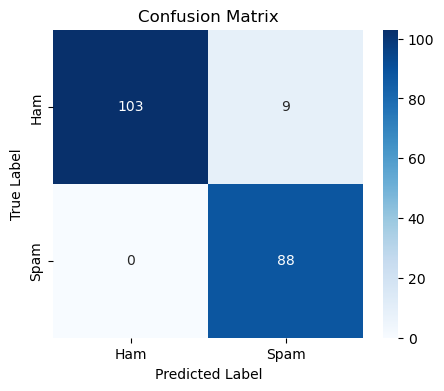

In [207]:
# Accuracy Score
accuracy = accuracy_score(y_val, y_pred)
print("\nModel Accuracy:", accuracy)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Ham", "Spam"], yticklabels=["Ham", "Spam"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


### Extra Task - Implement a SPAM/HAM classifier

https://www.kaggle.com/t/b384e34013d54d238490103bc3c360ce

The classifier can not be changed!!! It must be the MultinimialNB with default parameters!

Your task is to find the **best feature representation**.

You can work with teams of two persons (recommended).